# Oracle Risk Analysis: Price Movements

Analysis of 1-second and 5-second spot price movements for oracle risk assessment.

**Data Source**: Binance Spot API (supports 1s intervals)

In [1]:
import sys
sys.path.append('../src')

from risk_model.chart_config import setup_chart_style, COLORS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

setup_chart_style()

SYMBOLS = ["BTCUSDT", "ETHUSDT", "SOLUSDT", "PEPEUSDT"]
DATA_DIR = Path("../data/spot_klines")

## 1. Load Data

```bash
poetry run python scripts/download_klines.py --symbol BTCUSDT --days 365
```

In [2]:
dtype_spec = {'open': 'float32', 'high': 'float32', 'low': 'float32', 'close': 'float32', 'volume': 'float32'}

data = {}
for symbol in SYMBOLS:
    csv_path = DATA_DIR / f"{symbol}_1s.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path, parse_dates=['timestamp'], dtype=dtype_spec)
        days = (df['timestamp'].max() - df['timestamp'].min()).days
        print(f"{symbol}: {len(df):,} rows, {days} days")
        data[symbol] = df

print(f"\nLoaded {len(data)} symbols")

BTCUSDT: 31,561,740 rows, 365 days


ETHUSDT: 10,734,000 rows, 124 days


SOLUSDT: 10,480,000 rows, 121 days


PEPEUSDT: 10,574,000 rows, 122 days

Loaded 4 symbols


## 2. Calculate Returns (1s and 5s)

In [3]:
returns = {'1s': {}, '5s': {}}

for symbol, df in data.items():
    df = df.sort_values('timestamp').reset_index(drop=True)
    price = df['close']
    returns['1s'][symbol] = (price.pct_change(periods=1) * 100).dropna()
    returns['5s'][symbol] = (price.pct_change(periods=5) * 100).dropna()

print("Calculated 1s and 5s returns for all symbols")

Calculated 1s and 5s returns for all symbols


## 3. Distribution of Price Movements

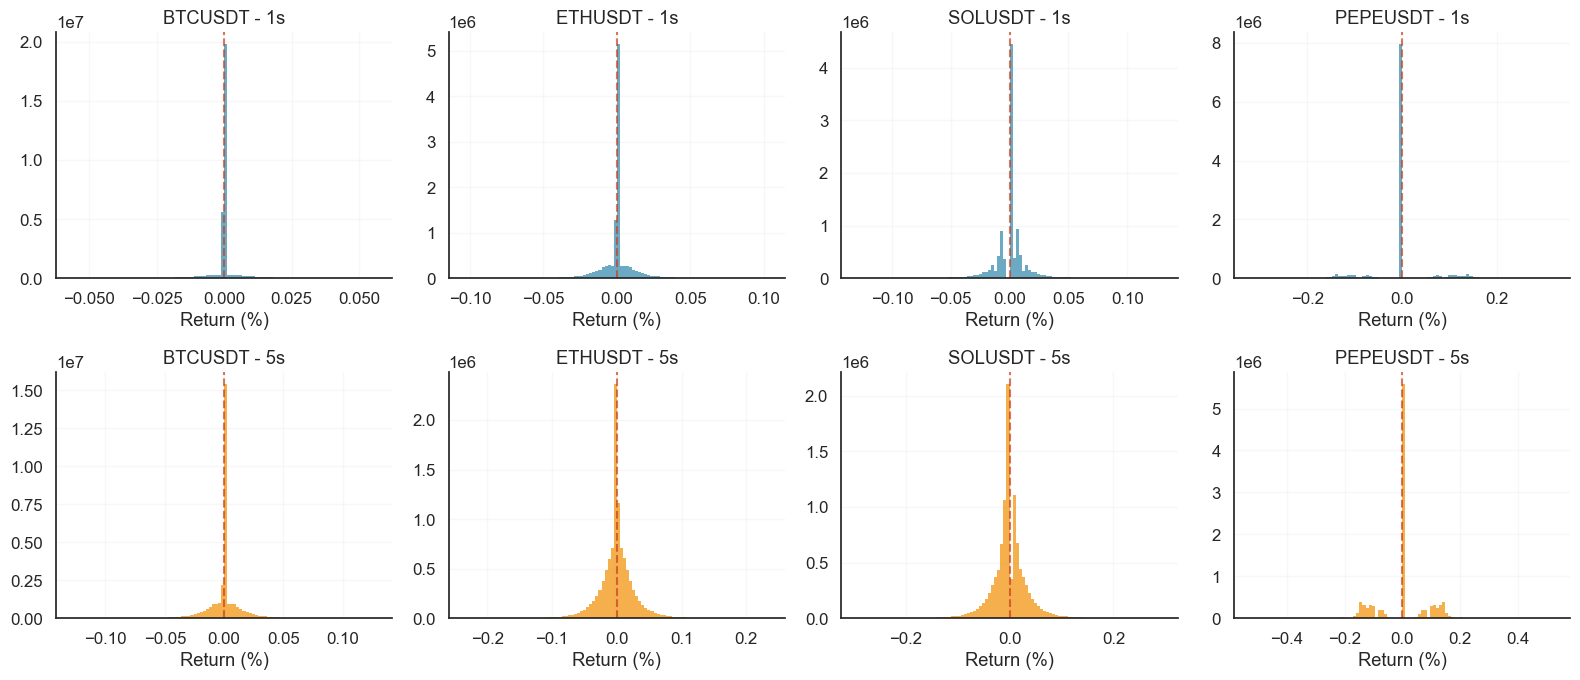

In [4]:
n_cols = len(data)
fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 7))
if n_cols == 1:
    axes = axes.reshape(2, 1)

for col_idx, symbol in enumerate(data.keys()):
    # 1s returns
    ax = axes[0, col_idx]
    ret = returns['1s'][symbol]
    q99 = ret.abs().quantile(0.99)
    plot_data = ret[ret.abs() <= q99 * 2]
    ax.hist(plot_data, bins=100, alpha=0.7, color=COLORS['primary'], edgecolor='none')
    ax.axvline(x=0, color=COLORS['danger'], linestyle='--', alpha=0.7)
    ax.set_title(f'{symbol} - 1s')
    ax.set_xlabel('Return (%)')
    ax.grid(True, alpha=0.3)
    
    # 5s returns
    ax = axes[1, col_idx]
    ret = returns['5s'][symbol]
    q99 = ret.abs().quantile(0.99)
    plot_data = ret[ret.abs() <= q99 * 2]
    ax.hist(plot_data, bins=100, alpha=0.7, color=COLORS['warning'], edgecolor='none')
    ax.axvline(x=0, color=COLORS['danger'], linestyle='--', alpha=0.7)
    ax.set_title(f'{symbol} - 5s')
    ax.set_xlabel('Return (%)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'returns_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Key Statistics (Absolute Movements)

In [5]:
# 1-second stats
stats_1s = []
for symbol in data.keys():
    abs_ret = returns['1s'][symbol].abs()
    stats_1s.append({
        'Symbol': symbol,
        'Mean': f"{abs_ret.mean():.4f}%",
        'p99': f"{abs_ret.quantile(0.99):.4f}%",
        'p99.5': f"{abs_ret.quantile(0.995):.4f}%",
        'p99.9': f"{abs_ret.quantile(0.999):.4f}%",
        'Max': f"{abs_ret.max():.4f}%",
    })

print("1-Second Absolute Return Statistics:")
display(pd.DataFrame(stats_1s))

1-Second Absolute Return Statistics:


,Symbol,Mean,p99,p99.5,p99.9,Max
0,BTCUSDT,0.0021%,0.0283%,0.0363%,0.0602%,3.2247%
1,ETHUSDT,0.0061%,0.0521%,0.0667%,0.1142%,1.9761%
2,SOLUSDT,0.0087%,0.0650%,0.0828%,0.1401%,1.2418%
3,PEPEUSDT,0.0272%,0.1613%,0.1733%,0.2774%,2.0093%


In [6]:
# 5-second stats
stats_5s = []
for symbol in data.keys():
    abs_ret = returns['5s'][symbol].abs()
    stats_5s.append({
        'Symbol': symbol,
        'Mean': f"{abs_ret.mean():.4f}%",
        'p99': f"{abs_ret.quantile(0.99):.4f}%",
        'p99.5': f"{abs_ret.quantile(0.995):.4f}%",
        'p99.9': f"{abs_ret.quantile(0.999):.4f}%",
        'Max': f"{abs_ret.max():.4f}%",
    })

print("5-Second Absolute Return Statistics:")
display(pd.DataFrame(stats_5s))

5-Second Absolute Return Statistics:


,Symbol,Mean,p99,p99.5,p99.9,Max
0,BTCUSDT,0.0079%,0.0644%,0.0809%,0.1314%,3.3836%
1,ETHUSDT,0.0187%,0.1181%,0.1506%,0.2569%,2.3399%
2,SOLUSDT,0.0242%,0.1471%,0.1868%,0.3109%,2.1240%
3,PEPEUSDT,0.0576%,0.2649%,0.2911%,0.3836%,2.7504%


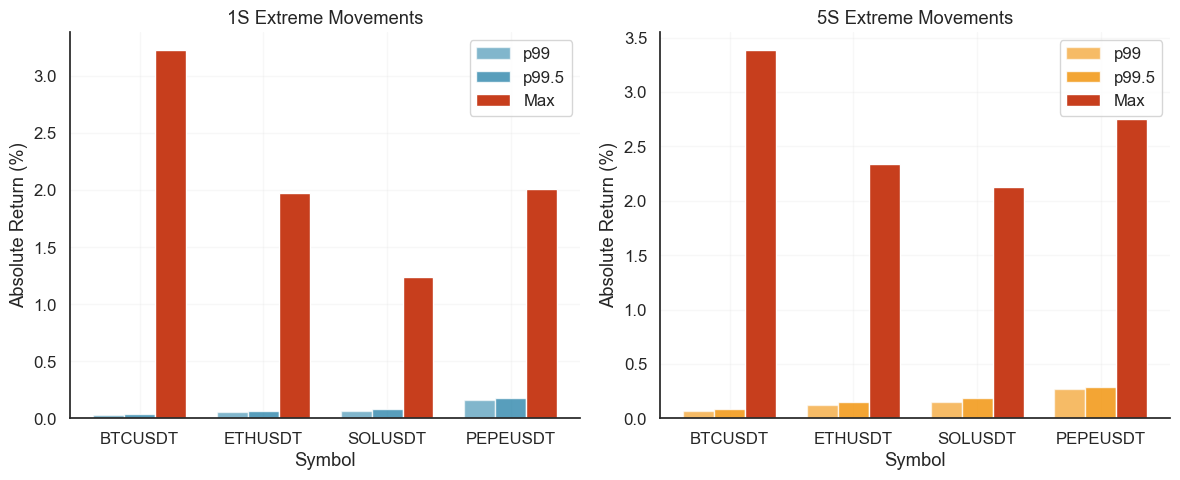

In [7]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

symbols_list = list(data.keys())
x = np.arange(len(symbols_list))
width = 0.25

for ax_idx, (window, color) in enumerate([('1s', COLORS['primary']), ('5s', COLORS['warning'])]):
    ax = axes[ax_idx]
    p99 = [returns[window][s].abs().quantile(0.99) for s in symbols_list]
    p995 = [returns[window][s].abs().quantile(0.995) for s in symbols_list]
    max_val = [returns[window][s].abs().max() for s in symbols_list]
    
    ax.bar(x - width, p99, width, label='p99', color=color, alpha=0.6)
    ax.bar(x, p995, width, label='p99.5', color=color, alpha=0.8)
    ax.bar(x + width, max_val, width, label='Max', color=COLORS['danger'])
    
    ax.set_xlabel('Symbol')
    ax.set_ylabel('Absolute Return (%)')
    ax.set_title(f'{window.upper()} Extreme Movements')
    ax.set_xticks(x)
    ax.set_xticklabels(symbols_list)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(DATA_DIR / 'extreme_movements.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Export Summary

In [8]:
summary = []
for symbol in data.keys():
    df = data[symbol]
    abs_1s = returns['1s'][symbol].abs()
    abs_5s = returns['5s'][symbol].abs()
    
    summary.append({
        'symbol': symbol,
        'data_start': df['timestamp'].min().strftime('%Y-%m-%d'),
        'data_end': df['timestamp'].max().strftime('%Y-%m-%d'),
        'total_rows': len(df),
        '1s_p99': abs_1s.quantile(0.99),
        '1s_p995': abs_1s.quantile(0.995),
        '1s_p999': abs_1s.quantile(0.999),
        '1s_max': abs_1s.max(),
        '5s_p99': abs_5s.quantile(0.99),
        '5s_p995': abs_5s.quantile(0.995),
        '5s_p999': abs_5s.quantile(0.999),
        '5s_max': abs_5s.max(),
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(DATA_DIR / 'oracle_risk_summary.csv', index=False)
print(f"Summary saved to {DATA_DIR / 'oracle_risk_summary.csv'}")
display(summary_df.round(4))

Summary saved to ../data/spot_klines/oracle_risk_summary.csv


,symbol,data_start,data_end,total_rows,1s_p99,1s_p995,1s_p999,1s_max,5s_p99,5s_p995,5s_p999,5s_max
0,BTCUSDT,2025-01-15,2026-01-15,31561740,0.0283,0.0363,0.0602,3.2247,0.0644,0.0809,0.1314,3.3836
1,ETHUSDT,2025-01-15,2025-05-19,10734000,0.0521,0.0667,0.1142,1.9761,0.1181,0.1506,0.2569,2.3399
2,SOLUSDT,2025-01-15,2025-05-16,10480000,0.0650,0.0828,0.1401,1.2418,0.1471,0.1868,0.3109,2.1240
3,PEPEUSDT,2025-01-15,2025-05-17,10574000,0.1613,0.1733,0.2774,2.0093,0.2649,0.2911,0.3836,2.7504
